# Clustering Documents

In this notebook, you'll learn about **Latent Dirichlet Allocation** (LDA) algorithm, and how to use it to cluster documents.

Key-learning:
- Unsupervised machine learning for NLP
- Clustering Documents
- LDA
- python packages: *pandas*, *gensim*

Terms in this notebook:
- Bag of words
- LDA
- Clustering
- TF/IDF

This notebook includes 2 recommended videos (total length: 25min).

Estimated exercise duration: 1-2h.


# Setup

We start by importing [pandas](https://pandas.pydata.org/) - an essential tool for data scientists!

We load a .CSV (Comma Seperated Values) file of German news articles from https://github.com/tblock/10kGNAD


In [1]:
from IPython.display import YouTubeVideo

In [2]:
import pandas as pd

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [25]:
df = pd.read_csv('https://raw.githubusercontent.com/tblock/10kGNAD/master/articles.csv', sep=';', on_bad_lines='skip', header=None, names=['category', 'content'])

In [24]:
df

,category,content
0,Etat,"Die ARD-Tochter Degeto hat sich verpflichtet, ..."
1,Etat,App sei nicht so angenommen worden wie geplant...
2,Etat,"'Zum Welttag der Suizidprävention ist es Zeit,..."
3,Etat,Mitarbeiter überreichten Eigentümervertretern ...
4,Etat,Service: Jobwechsel in der Kommunikationsbranc...
...,...,...
10268,Wissenschaft,Die Fundstelle in Südengland ist Unesco-Weltku...
10269,Wissenschaft,Im Team arbeitet auch ein Inspektor der sudane...
10270,Wissenschaft,Die zentrale Frage des Projekts: Siedelten Ägy...
10271,Wissenschaft,Klimatische Verschlechterungen dürften zur Auf...


# Clustering with Latent Dirichlet Allocation (LDA)

## Introduction

We start by clustering our data as an unsupervised learning task: **topic modeling**.

There are many different methods to cluster documents. One of these methods is topic modeling - where an algorithm assigns a topic to each document and clusters these documents by these topics.

Documents can be represented as a distribution of their words: their occurrences and frequencies. A set of words, which are relatively not frequent but are common to several documents, can express a document topic.
For example, suppose we locate documents with the words 'Android', 'OnePlus' and 'iPhone' in them. Based on the frequency of these words, we could assume that these documents are related to mobile phones.

[Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution) is a distribution on probability distributions. In other words, it can handle the frequency of which a set of words appear (which have by themselves, each one, a frequency).

For a deeper mathematical explanation of this distribution, watch this recommended video: https://www.youtube.com/watch?v=nfBNOWv1pgE

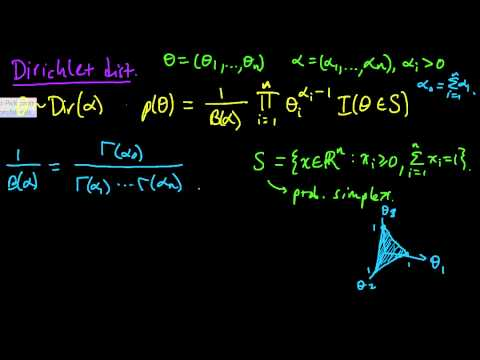

In [4]:
YouTubeVideo('nfBNOWv1pgE')

LDA is an unsupervised algorithm that assigns topics to every document. These topics are described as a set of words.
Each document can contain more than one topic.
For example, some article about Apple can be 80% mobile phones and 20% about business innovations or income.

LDA paper is a milestone in NLP and one of the recommended readings.

If you're interested to learn more about the algorithm method, watch this video: https://www.youtube.com/watch?v=DWJYZq_fQ2A.

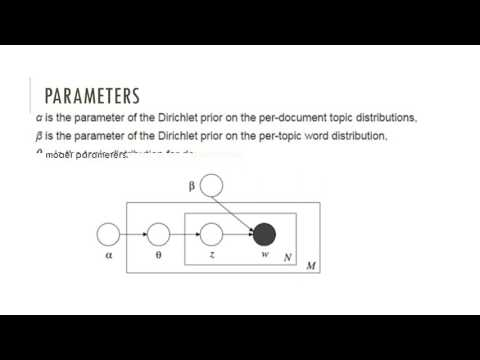

In [5]:
YouTubeVideo('DWJYZq_fQ2A')

Now, let's examine our German data set with LDA:

In the previous exercises, you got to know NLTK. 

Here we will also use NLTK's methods of **stemming** the words. By returning to the root of the word, its stem, we reduce the dimensionality: the number of words in the vocabulary decreases. For example, instead of having different words for the singular and plural form - 'word' <--> 'words' or 'Kanzler', 'Kanzlers', 'Kanzlei', etc., we trim those words into 'Kanzl'. Hence we can reduce the size of the vocabulary by at least half.

We will also remove `stopwords` from our text. In English, words such as: `a`, `an`, and `the` will be removed, as they don't add much to the meaning of the sentence. For each language, there is a different curated list of such words, and NLTK is a great source for those.

In this exercise, you'll be introduced to another package, specialized in topic modeling, called `gensim`:
https://radimrehurek.com/gensim/



In [51]:
from pprint import pprint # for printing objects nicely

from gensim import corpora, models
from gensim.utils import simple_preprocess

# from gensim.parsing.preprocessing import STOPWORDS 
# Instead of the gensim english stopwords, we use nltk's German stopwords
from nltk.corpus import stopwords

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

import numpy as np

from random import choice

np.random.seed(1234)

stemmer = SnowballStemmer('german')
german_stop_words = set(stopwords.words('german'))


def lemmatize_stemming(text):
  return stemmer.stem(text)

def preprocess(text):
  result = [lemmatize_stemming(token) 
            for token in simple_preprocess(text)  
            if token not in german_stop_words and len(token) > 3]
  return result


In our DataFrame, we have a table contains the articles and their topics.

We only need the articles for this tasks - we will create our own topics. So, let's start by converting the articles column into a ist of all the articles:

In [7]:
all_articles = df['content'].to_list()
all_articles[:5]

['Die ARD-Tochter Degeto hat sich verpflichtet, ab August einer Quotenregelung zu folgen, die für die Gleichstellung von Regisseurinnen sorgen soll. In mindestens 20 Prozent der Filme, die die ARD-Tochter Degeto produziert oder mitfinanziert, sollen ab Mitte August Frauen Regie führen. Degeto-Chefin Christine Strobl folgt mit dieser Selbstverpflichtung der Forderung von Pro Quote Regie. Die Vereinigung von Regisseurinnen hatte im vergangenen Jahr eine Quotenregelung gefordert, um den weiblichen Filmschaffenden mehr Gehör und ökonomische Gleichstellung zu verschaffen. Pro Quote Regie kritisiert, dass, während rund 50 Prozent der Regie-Studierenden weiblich seien, der Anteil der Regisseurinnen bei Fernsehfilmen nur bei 13 bis 15 Prozent liege. In Österreich sieht die Situation ähnlich aus, auch hier wird von unterschiedlichen Seiten Handlungsbedarf angemahnt. Aber wie soll dieser aussehen? Ist die Einführung der Quotenregelung auch für die österreichische Film- und Fernsehlandschaft sinn

## Preprocessing

Let's see an example, what happens when we pre-process a document.

Look at the output of this cell, and compare the tokenized original document, to the lemmatized document:

In [33]:
print('original document: ')
article = choice(all_articles)
print(article)

# This time, we don't care about punctuations as tokens (Can you think why?):
print('original document, broken into words: ')
words = [word for word in article.split(' ')]
print(words)
print("Vocabulary size of the original article:", len(set(words)))

# now let's see what happens when we pass the article into our preprocessing 
# method:
print('\n\n tokenized and lemmatized document: ')
preprocessed_article = preprocess(article)
print(preprocessed_article)
print("Vocabulary size after preprocessing:", len(set(preprocessed_article)))


original document: 
'Zweitschlechtester Wert seit Messung 1974. Hollywood – Mit 34,3 Millionen Zuschauern bei der 88. Oscar-Verleihung muss der US-Sender ABC die niedrigste Einschaltquote für die Gala seit acht Jahren verkraften. Das Marktforschungsinstitut Nielsen ermittelte demnach den zweitschlechtesten Wert für die TV-Übertragung der Preisvergabe seit Messung 1974. Den Negativrekord hält weiter das Jahr 2008, als lediglich 32 Millionen Amerikaner einschalteten. Unklar ist, ob die Debatte um die erneut rein weiße Nominierungsliste in den Schauspielsparten und der damit verbundene Protest und Boykottaufruf durch Pastor Al Sharpton dafür verantwortlich ist. Schon im Vorjahr musste ABC mit 36,6 Millionen Zusehern bei der von Neil Patrick Harris moderierten Verleihung einen Rückgang von 18 Prozent gegenüber 2014 hinnehmen. Der mit Spannung erwartete, von Kritikern gefeierte Eröffnungsmonolog des afroamerikanischen Komikers Chris Rock sowie der erste Oscar für Leonardo DiCaprio konnten d

Now let's pre-process them all.

This is a heavy procedure, and may take a bit ;)

In [29]:
processed_docs = list(map(preprocess, all_articles))
processed_docs[:10]

[['tocht',
  'degeto',
  'verpflichtet',
  'august',
  'quotenregel',
  'folg',
  'gleichstell',
  'regisseurinn',
  'sorg',
  'mindest',
  'prozent',
  'film',
  'tocht',
  'degeto',
  'produziert',
  'mitfinanziert',
  'soll',
  'mitt',
  'august',
  'frau',
  'regi',
  'fuhr',
  'degeto',
  'chefin',
  'christin',
  'strobl',
  'folgt',
  'forder',
  'quot',
  'regi',
  'verein',
  'regisseurinn',
  'vergang',
  'jahr',
  'quotenregel',
  'gefordert',
  'weiblich',
  'filmschaff',
  'mehr',
  'gehor',
  'okonom',
  'gleichstell',
  'verschaff',
  'quot',
  'regi',
  'kritisiert',
  'rund',
  'prozent',
  'regi',
  'studier',
  'weiblich',
  'seien',
  'anteil',
  'regisseurinn',
  'fernsehfilm',
  'prozent',
  'lieg',
  'osterreich',
  'sieht',
  'situation',
  'ahnlich',
  'seit',
  'handlungsbedarf',
  'angemahnt',
  'ausseh',
  'einfuhr',
  'quotenregel',
  'osterreich',
  'film',
  'sinnvoll',
  'diskuti',
  'forum'],
 ['angenomm',
  'word',
  'geplant',
  'weg',
  'gering',
  '

## Setting Up The Dictionary

Our preprocessing is complete.
 
We now need to calculate the occurance frequencies of each of our stemmed words. But first, we will create a vocabulary dictionary where every word appears once. Every article would be represented as a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model), an unordered set of words that the article contain.

---

Q: Why is it called bag-of-words? 

Hint: Think about your probability lessons - where you had randomly picked out white or black balls out of a bag...

In [34]:
dictionary = corpora.Dictionary(processed_docs)


Let's take a look:

In [38]:
for idx, (k, v) in enumerate(dictionary.iteritems()):
    print(k, v)
    if idx >= 10:
        break


### Note: `enumerate` is a great python function! 
### It creates an index, a counter, for every object in the collection.
### read more about it here: https://realpython.com/python-enumerate/ 

0 ahnlich
1 angemahnt
2 anteil
3 august
4 ausseh
5 chefin
6 christin
7 degeto
8 diskuti
9 einfuhr
10 fernsehfilm


Second, we filter the tokens that may appear to often.

We have full control on the process. 

### Model Hyperparameter tuning

#### Exercise 1: 
Q: How would changing these parameters influence the result?

After running this example, please return here to change them and try them out.

In [39]:
## Model hyper parameters:

## These are the dictionary preparation parameters:
filter_tokens_if_container_documents_are_less_than = 15
filter_tokens_if_appeared_percentage_more_than = 0.5
keep_the_first_n_tokens=100000

## and the LDA Parameters: 
num_of_topics = 10

In [13]:
dictionary.filter_extremes(
    no_below=filter_tokens_if_container_documents_are_less_than, 
    no_above=filter_tokens_if_appeared_percentage_more_than, 
    keep_n=keep_the_first_n_tokens)


We now create a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) (BOW) dictionary for each document. 

It will be in the format of:

```{ 'word_id': count }```


In [14]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

Let's take a look at the result.

Our corpus contains now only word_ids, not the words themselves, so we have to peek into the dictionary to know which word that id represents:

In [46]:
# randomly choose an article from the corpus:
sample_bow_doc = choice(bow_corpus)

print('The processed bag-of-word document is just pairs of (word_id, # of occurnces) and looks like this:')
print(sample_bow_doc, '\n\n')

print ('We peek in the dictionary: for each word_id, we get its assigned word:')
for word_id, word_freq in sample_bow_doc:
  real_word = dictionary[word_id]
  print(f'Word {word_id} ("{real_word}") appears {word_freq} time.')


The processed bag-of-word document is just pairs of (word_id, # of occurnces) and looks like this:
[(25, 1), (32, 2), (50, 4), (61, 1), (62, 3), (63, 1), (116, 1), (180, 1), (181, 1), (185, 2), (187, 1), (189, 2), (209, 1), (220, 1), (221, 1), (273, 2), (281, 1), (303, 1), (313, 1), (316, 1), (325, 2), (351, 2), (357, 2), (384, 1), (394, 1), (411, 3), (418, 1), (438, 1), (439, 3), (452, 1), (458, 1), (463, 1), (537, 1), (544, 2), (553, 3), (560, 1), (572, 3), (582, 1), (586, 1), (701, 1), (705, 1), (760, 1), (762, 1), (798, 1), (820, 5), (826, 1), (842, 1), (861, 1), (912, 1), (936, 1), (1051, 1), (1059, 1), (1071, 1), (1095, 1), (1144, 1), (1159, 1), (1211, 1), (1261, 1), (1312, 1), (1343, 1), (1369, 1), (1444, 1), (1480, 1), (1484, 1), (1532, 1), (1667, 1), (1789, 1), (1845, 1), (1855, 1), (2071, 1), (2088, 1), (2140, 1), (2141, 1), (2147, 1), (2203, 1), (2440, 1), (2577, 1), (2624, 2), (2692, 1), (2804, 1), (3038, 1), (3046, 1), (3423, 2), (3453, 1), (3616, 1), (3618, 1), (3921, 1),

## LDA model using Bag-of-words

Let's start by applying the LDA model using the bag-of-words (Warning: this could take a while):

In [52]:
lda_model = models.LdaMulticore(bow_corpus, num_topics=num_of_topics, id2word=dictionary, passes=2, workers=2)

It's done!

Now let's observe the created topics.

We will loop over the extracted topics and examine the words that construct them.

In [58]:
for idx, topic in lda_model.print_topics(num_of_topics):
    print(f'Topic: {idx} \t Words: {topic}')


Topic: 0 	 Words: 0.005*"william" + 0.005*"gefordert" + 0.005*"denkt" + 0.005*"wort" + 0.004*"iron" + 0.004*"produziert" + 0.004*"stark" + 0.004*"macht" + 0.003*"pet" + 0.003*"zwolf"
Topic: 1 	 Words: 0.009*"mindest" + 0.007*"lieg" + 0.006*"gefordert" + 0.005*"februar" + 0.004*"william" + 0.004*"gehemmt" + 0.003*"stark" + 0.003*"foto" + 0.003*"iron" + 0.003*"zugewies"
Topic: 2 	 Words: 0.007*"denkt" + 0.007*"mindest" + 0.007*"gefordert" + 0.006*"februar" + 0.006*"stark" + 0.005*"william" + 0.005*"iron" + 0.005*"lieg" + 0.004*"produziert" + 0.004*"gekostet"
Topic: 3 	 Words: 0.008*"gefordert" + 0.006*"william" + 0.005*"iron" + 0.005*"stark" + 0.004*"hoh" + 0.004*"denkt" + 0.004*"detailliert" + 0.004*"foto" + 0.003*"anchorman" + 0.003*"produziert"
Topic: 4 	 Words: 0.009*"gefordert" + 0.006*"februar" + 0.006*"iron" + 0.005*"mindest" + 0.005*"probl" + 0.005*"denkt" + 0.004*"macht" + 0.004*"produziert" + 0.004*"william" + 0.004*"lieg"
Topic: 5 	 Words: 0.018*"mindest" + 0.007*"gefordert" +

## TF / IDF

Let's take it one step further. We will cluster our document by running the LDA using [TF/IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).

We start with TF/IDF calculation on our bag-of-words.
TF/IDF accepts a dictionary of word frequencies as an input, and it calculates the term frequency and the inversed document frequency accordingly.

Its output is a re-weighted dictionary of the documents term frequencies:

In [18]:
tfidf = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

for doc in tfidf_corpus:
    pprint(doc)
    break


[(0, 0.07701104184392196),
 (1, 0.09759319572760512),
 (2, 0.17865097755146575),
 (3, 0.12576090253155267),
 (4, 0.1213785897586335),
 (5, 0.14966250355427194),
 (6, 0.12018647403621047),
 (7, 0.10920625806276203),
 (8, 0.19098038980835488),
 (9, 0.06256739336574345),
 (10, 0.08731418138743945),
 (11, 0.08647740625891134),
 (12, 0.14032936757689066),
 (13, 0.06577036204104757),
 (14, 0.07405575155931744),
 (15, 0.08932548877573288),
 (16, 0.09072789199095227),
 (17, 0.33117488361905073),
 (18, 0.15948795931092485),
 (19, 0.020273454088271383),
 (20, 0.0790627311642285),
 (21, 0.07726479954315345),
 (22, 0.08357012518526766),
 (23, 0.08069377542776295),
 (24, 0.1167129985832824),
 (25, 0.07975467566677337),
 (26, 0.11654151351208203),
 (27, 0.14006253783120604),
 (28, 0.23588700353404207),
 (29, 0.512947931753448),
 (30, 0.03877051844587956),
 (31, 0.046501312545973304),
 (32, 0.027372494763772317),
 (33, 0.06401699265145537),
 (34, 0.11980004049538755),
 (35, 0.08247600216314194),
 (36

Now let's apply LDA on the tfidf corpus, with the same amount of topics.

In [54]:
lda_model_tfidf = models.LdaMulticore(tfidf_corpus, num_topics=num_of_topics, id2word=dictionary, passes=2, workers=4)

Topic: 0 	 Word: 0.001*"februar" + 0.001*"zwischenwass" + 0.001*"abseit" + 0.001*"lieg" + 0.001*"allerwen" + 0.001*"zugewies" + 0.001*"abgehau" + 0.001*"advertising" + 0.001*"probl" + 0.001*"mindest"
Topic: 1 	 Word: 0.002*"zwischenwass" + 0.002*"abseit" + 0.002*"allerwen" + 0.002*"advertising" + 0.001*"abgehau" + 0.001*"frei" + 0.001*"mindest" + 0.001*"blog" + 0.001*"statt" + 0.001*"februar"
Topic: 2 	 Word: 0.001*"international" + 0.001*"schalt" + 0.001*"verliert" + 0.001*"februar" + 0.001*"statt" + 0.001*"mindest" + 0.001*"abdel" + 0.001*"iron" + 0.001*"grosst" + 0.001*"probl"
Topic: 3 	 Word: 0.003*"mindest" + 0.002*"februar" + 0.001*"lieg" + 0.001*"nostalgi" + 0.001*"gefordert" + 0.001*"probl" + 0.001*"pet" + 0.001*"vertraulich" + 0.001*"unbekannt" + 0.001*"schaff"
Topic: 4 	 Word: 0.001*"stark" + 0.001*"vermiss" + 0.001*"antlitz" + 0.001*"gefordert" + 0.001*"liv" + 0.001*"mindest" + 0.001*"februar" + 0.001*"hoh" + 0.001*"william" + 0.001*"filmverband"
Topic: 5 	 Word: 0.001*"febr

In [57]:
for idx, topic in lda_model_tfidf.print_topics(num_of_topics):
    print(f'Topic: {idx} \t Word: {topic}')

Topic: 0 	 Word: 0.001*"februar" + 0.001*"zwischenwass" + 0.001*"abseit" + 0.001*"lieg" + 0.001*"allerwen" + 0.001*"zugewies" + 0.001*"abgehau" + 0.001*"advertising" + 0.001*"probl" + 0.001*"mindest"
Topic: 1 	 Word: 0.002*"zwischenwass" + 0.002*"abseit" + 0.002*"allerwen" + 0.002*"advertising" + 0.001*"abgehau" + 0.001*"frei" + 0.001*"mindest" + 0.001*"blog" + 0.001*"statt" + 0.001*"februar"
Topic: 2 	 Word: 0.001*"international" + 0.001*"schalt" + 0.001*"verliert" + 0.001*"februar" + 0.001*"statt" + 0.001*"mindest" + 0.001*"abdel" + 0.001*"iron" + 0.001*"grosst" + 0.001*"probl"
Topic: 3 	 Word: 0.003*"mindest" + 0.002*"februar" + 0.001*"lieg" + 0.001*"nostalgi" + 0.001*"gefordert" + 0.001*"probl" + 0.001*"pet" + 0.001*"vertraulich" + 0.001*"unbekannt" + 0.001*"schaff"
Topic: 4 	 Word: 0.001*"stark" + 0.001*"vermiss" + 0.001*"antlitz" + 0.001*"gefordert" + 0.001*"liv" + 0.001*"mindest" + 0.001*"februar" + 0.001*"hoh" + 0.001*"william" + 0.001*"filmverband"
Topic: 5 	 Word: 0.001*"febr

## Inference

Now that we have a topic-modeler, let's use it on one of the articles.

In [60]:
# randomly pick an article:
test_doc = choice(range(len(processed_docs)))
processed_docs[test_doc]

['auffass',
 'konkret',
 'massnahm',
 'kais',
 'aufnehm',
 'wien',
 'land',
 'gemeind',
 'regier',
 'mittwoch',
 'gemeinsam',
 'position',
 'festleg',
 'ziel',
 'gesamtzahl',
 'fluchtling',
 'deutlich',
 'reduzi',
 'sagt',
 'sprecherin',
 'kanzl',
 'wern',
 'faymann',
 'darub',
 'seien',
 'beteiligt',
 'auffass',
 'gibt',
 'konkret',
 'massnahm',
 'aussenminist',
 'sebastian',
 'kurz',
 'stellt',
 'konkret',
 'massnahm',
 'etwa',
 'beschluss',
 'aussicht',
 'plan',
 'formuliert',
 'faymann',
 'sprecherin',
 'montag',
 'gemeinsam',
 'position',
 'erarbeit',
 'konkret',
 'ziel',
 'gesamtzahl',
 'deutlich',
 'reduzi',
 'wenig',
 'fluchtling',
 'land',
 'komm',
 'soll',
 'nennt',
 'zwei',
 'konkret',
 'massnahm',
 'ziel',
 'erreich',
 'einerseit',
 'woll',
 'wesent',
 'mehr',
 'ruckfuhr',
 'der',
 'heimatland',
 'praktisch',
 'verbesser',
 'ruckfuhr',
 'erreicht',
 'andererseit',
 'strebt',
 'bess',
 'kontroll',
 'grenz',
 'faymann',
 'bereit',
 'gutacht',
 'beim',
 'auftrag',
 'gegeb',
 '

Using the original BOW model:

In [65]:
for index, score in sorted(lda_model[bow_corpus[test_doc]], key=lambda tup: -1*tup[1]):
    print(f"Score: {score} \nTopic: {lda_model.print_topic(index, num_of_topics)}")


Score: 0.9977267384529114 
Topic: 0.011*"vertraulich" + 0.008*"lieg" + 0.007*"wort" + 0.006*"william" + 0.006*"pet" + 0.005*"hoh" + 0.005*"stark" + 0.004*"gefordert" + 0.004*"unbekannt" + 0.004*"produziert"


And with the TF/IDF model:

In [66]:
for index, score in sorted(lda_model_tfidf[bow_corpus[test_doc]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, num_of_topics)))


Score: 0.9977269172668457	 
Topic: 0.003*"mindest" + 0.002*"februar" + 0.001*"lieg" + 0.001*"nostalgi" + 0.001*"gefordert" + 0.001*"probl" + 0.001*"pet" + 0.001*"vertraulich" + 0.001*"unbekannt" + 0.001*"schaff"


### Exercise - inference

Now try it on a new document!

Go to a news website, such as [orf.at](https://orf.at/) and copy an article of your choice here:

In [23]:
unseen_document = """Sobotka sprach in einer um eineinhalb Stunden verspäteten Pressekonferenz am Abend von einer „schwierigen“, aber „sachlichen und pointierten“ Diskussion im Hauptausschuss. Er meinte, dass von Gesundheitsminister Rudolf Anschober (Grüne), die „Notwendigkeit, Verhältnismäßigkeit und Richtigkeit“ der Maßnahmen erläutert worden seien. Zudem betonte Sobotka die Wichtigkeit der im Covid-Maßnahmengesetz vorgesehenen Mitsprache des Parlaments bei Maßnahmen, bei denen auch die Freiheitsrechte betroffen seien.
Der Nationalratspräsident zitierte auch die deutsche Kanzlerin Angela Merkel, die die Maßnahmen im Kampf gegen die Pandemie als „demokratische Zumutung“ bezeichnet hatte. Dem sei nicht nur zuzustimmen, das sei auch zu unterstreichen, sagte er. Die Eindämmung der Pandemie könne aber nur gelingen, wenn sich alle Österreicher einbringen. Der Beschluss alleine reiche nicht, die Maßnahmen müssten auch im Geiste verinnerlicht werden, appellierte Sobotka an die Bevölkerung, die Maßnahmen mitzutragen.
Rendi-Wagner kritisiert Regierung
Die Opposition hatte schon vor der Sitzung – und dann auch noch einmal danach – ihre Kritik an der Regierung bekräftigt. „Die Bundesregierung hat die Kontrolle über das Infektionsgeschehen verloren und hat die schwierige Situation, vor der wir jetzt stehen, zu verantworten“, kritisierte SPÖ-Klub- und Parteivorsitzende Rendi-Wagner.
Sessel auf Tischen in einem geschlossenen Lokal
DEBATTEWie gerechtfertigt sind die Maßnahmen?"""

bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))


Score: 0.9891536831855774	 Topic: 0.008*"sagt" + 0.008*"jahr" + 0.006*"seit" + 0.004*"erst" + 0.004*"neu"


# Exercise - Your turn:

Replace the given corpus with one in another language - maybe your own native language? You can find corpus here: https://www.corpusdata.org/intro.asp. 

Careful: You will need to change the [Stemming](https://snowballstem.org/algorithms/) and the [Stopwords](https://www.kaggle.com/rtatman/stopword-lists-for-19-languages) to support your language. Make a web-search after the appropriate ones. 

Use the notebook to reproduce the result.

Try changing the parameters to get a *satisfying level of clustering*.

Which parameters worked best for the language you chose? 